# Optimizing the KSD (2D)

In [1]:
%load_ext autoreload
from jax import config
# config.update("jax_log_compiles", True)
# config.update("jax_debug_nans", True)
# config.update("jax_disable_jit", True)

import sys
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd/kernel_learning/")
from functools import partial
from itertools import product

from tqdm import tqdm
import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd, value_and_grad
from jax import lax
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import numpy as onp
import jax
import pandas as pd
import haiku as hk
from jax.experimental import optimizers

import config

import utils
import metrics
import time
import plot
import stein
import kernels
import distributions
import nets
import models

from jax.experimental import optimizers

key = random.PRNGKey(0)
key, subkey = random.split(key)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
@partial(jit, static_argnums=1)
def get_sd(samples, fun):
    return stein.stein_discrepancy(samples, target.logpdf, fun)

def get_ksds(kernel):
    """Return 100 ksds between prop and target"""
    @jit
    def compute_ksd(samples):
        return stein.ksd_squared_u(samples, target.logpdf, kernel)
    ksds_squared = []
    for _ in tqdm(range(100)):
        samples = proposal.sample(400)
        ksds_squared.append(compute_ksd(samples))
    ksds = ksds_squared
    return ksds

# Parameters

In [3]:
%autoreload

/home/lauro/code/msc-thesis/svgd/kernel_learning/plot.py:200: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  return ax.pcolormesh(*meshgrid, cmap=cmap, **kwargs)
/home/lauro/code/msc-thesis/svgd/kernel_learning/plot.py:198: UserWarning: No contour levels were found within the data range.
  return ax.contour(*meshgrid, **kwargs)


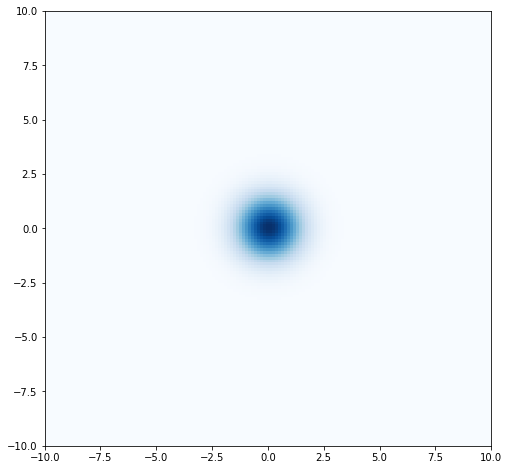

In [174]:
# setup = distributions.banana_proposal
# target, proposal = setup.get()

target = distributions.Gaussian([0, 0], [1e-9, 9])
proposal = distributions.Gaussian([0,0], 1)
setup = distributions.Setup(target, proposal)
sizes = None
learning_rate = 1e-1
lambda_reg=1/2
sample_every=True

fig, ax = plt.subplots(figsize=[8, 8])
setup.plot(lims=(-10, 10))

# Train

In [175]:
%autoreload

In [176]:
learner = models.KernelLearner(target,
                               key=key,
                               sizes=sizes,
                               learning_rate=learning_rate,
                              patience=0)
batch_size = 50

In [177]:
samples = proposal.sample(batch_size)
learner.step(samples, samples)

In [178]:
key, subkey = random.split(key)
val_x = proposal.sample(40)
def next_batch(key):
    train_x = proposal.sample(batch_size, key=key)
    return train_x, val_x
if sample_every:
    learner.train(next_batch, n_steps=500, progress_bar=True)
else:
    raise
#     learner.train(, n_steps=10, progress_bar=True)

100%|██████████| 500/500 [00:05<00:00, 84.34it/s]


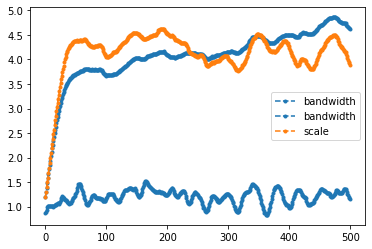

In [180]:
paramtree = utils.dict_concatenate(learner.rundata["model_params"])

leaves, structure = jax.tree_flatten(paramtree)

h = np.array(leaves[0])
s = np.array(leaves[1])

%matplotlib inline
plt.plot(h, "--.", label="bandwidth", color="tab:blue")
plt.plot(s, "--.", label="scale", color="tab:orange")
plt.legend()

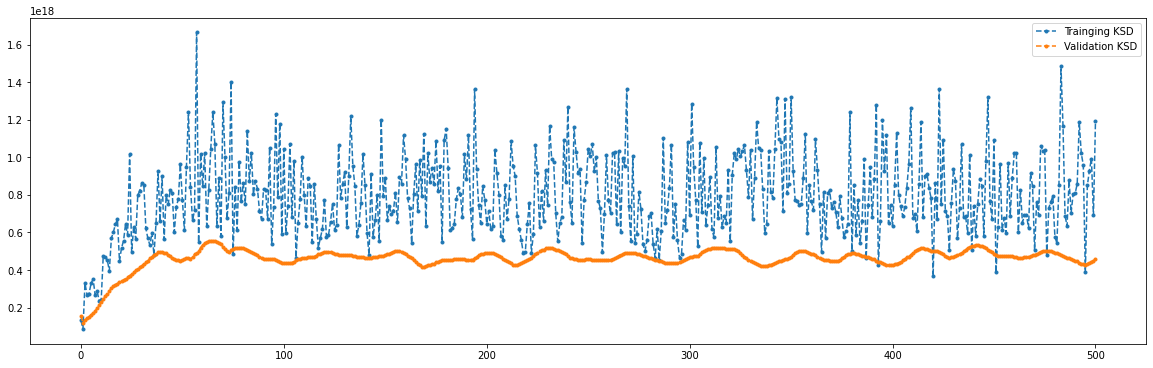

In [173]:
%matplotlib inline
plt.subplots(figsize=[20, 6])
plt.plot(learner.rundata["training_ksd"], "--.", label="Trainging KSD")
plt.plot(learner.rundata["validation_ksd"], "--.", label="Validation KSD")
plt.legend()

In [139]:
inducing_samples = proposal.sample(500)
learned_phistar = utils.negative(learner.get_field(inducing_samples))
def optimal_phistar(x):
    div = 2*learner.lambda_reg
    return grad(lambda x: target.logpdf(x) - proposal.logpdf(x))(x) / div

# compute optimal KSD
sds = []
for _ in range(100):
    samples = proposal.sample(400)
    sds.append(get_sd(samples, optimal_phistar))

# Plot result (should be the same)

Plot results:


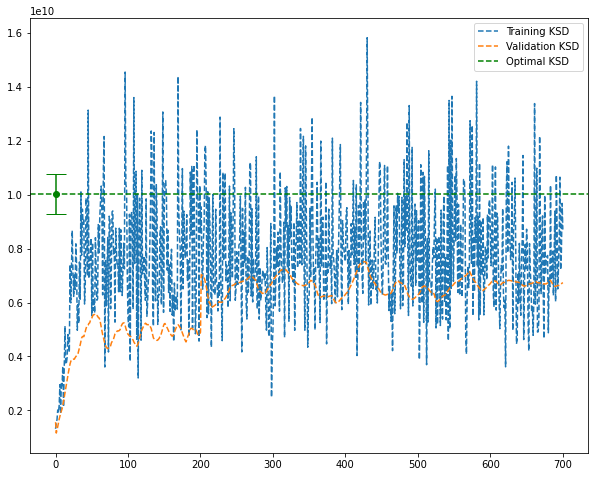

In [140]:
print("Plot results:")

rundata = learner.rundata
fig, ax = plt.subplots(figsize=[10,8])
plt.plot(rundata["training_ksd"], "--", label="Training KSD")
plt.plot(rundata["validation_ksd"], "--", label="Validation KSD")
# plt.errorbar(x=0, y=onp.mean(ksds_pre), yerr=onp.std(ksds_pre), fmt="o", capsize=10)
# plt.errorbar(x=len(rundata["loss"]), y=onp.mean(ksds_post), yerr=onp.std(ksds_post), fmt="o", capsize=10, color="b")
plt.errorbar(x=0, y=onp.mean(sds), yerr=onp.std(sds), fmt="o", capsize=10, color="green")
plt.axhline(y=onp.mean(sds), linestyle="--", label="Optimal KSD", color="green")
plt.legend()

## learned stein gradient

In [141]:
rescaled_kl_gradient = utils.negative(optimal_phistar)
learned_stein_gradient = learner.get_field(samples)
rescaled_rbf_stein_gradient = stein.get_phistar(kernels.get_rbf_kernel(1), target.logpdf, samples)
rescaled_rbf_stein_gradient = utils.mul(rescaled_rbf_stein_gradient, -10)

/home/lauro/code/msc-thesis/svgd/kernel_learning/plot.py:200: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  return ax.pcolormesh(*meshgrid, cmap=cmap, **kwargs)


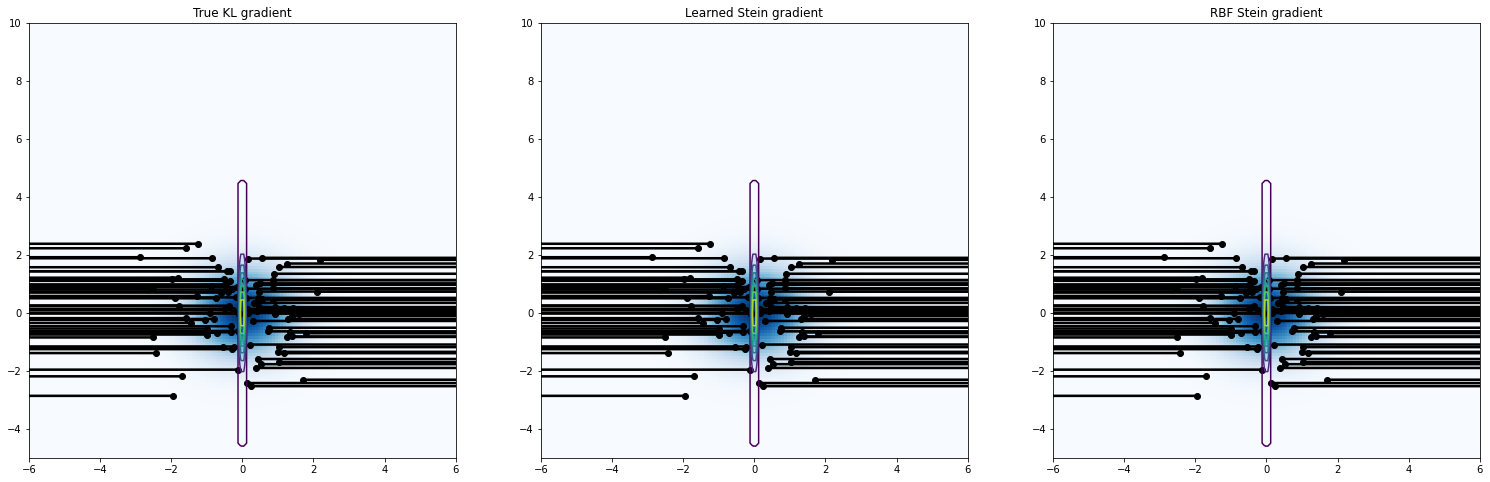

In [142]:
fig, axs = plt.subplots(1, 3, figsize=[26,8])
axs = axs.flatten()
def log_diff(x):
    return (target.logpdf(x) - proposal.logpdf(x)) / div

samples = None
samples = proposal.sample(100)
xlims = [-6, 6]
ylims = [-5, 10]
fields = (rescaled_kl_gradient, learned_stein_gradient, rescaled_rbf_stein_gradient)
scales = (20, 1e-1, 20)
titles = ("True KL gradient", "Learned Stein gradient", "RBF Stein gradient")
for ax, vector_field, scale, title in zip(axs, fields, scales, titles):
#     ax.pcolormesh(xx, yy, zz, vmin=-50, vmax=1, cmap="Blues")
    setup.plot(ax=ax, xlims=xlims, ylims=ylims)
    plot.quiverplot(vector_field, samples=samples, num_gridpoints=10, scale=scale, xlims=xlims, ylims=ylims, ax=ax)
    ax.set_ylim(ylims)
    ax.set_title(title)

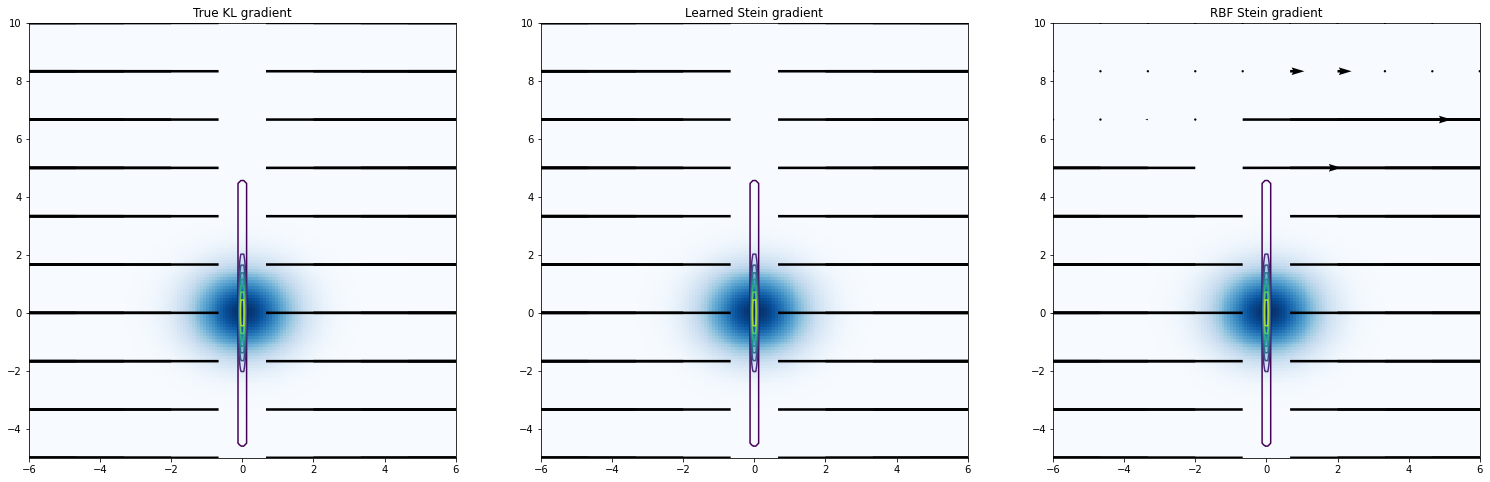

In [143]:
fig, axs = plt.subplots(1, 3, figsize=[26,8])
axs = axs.flatten()
def log_diff(x):
    return (target.logpdf(x) - proposal.logpdf(x)) / div

samples = None
# samples = proposal.sample(100)
xlims = [-6, 6]
ylims = [-5, 10]
fields = (rescaled_kl_gradient, learned_stein_gradient, rescaled_rbf_stein_gradient)
scales = np.array((100, 1, 1)) * 10
titles = ("True KL gradient", "Learned Stein gradient", "RBF Stein gradient")
for ax, vector_field, scale, title in zip(axs, fields, scales, titles):
#     ax.pcolormesh(xx, yy, zz, vmin=-50, vmax=1, cmap="Blues")
    setup.plot(ax=ax, xlims=xlims, ylims=ylims)
    plot.quiverplot(vector_field, samples=samples, num_gridpoints=10, scale=scale, xlims=xlims, ylims=ylims, ax=ax)
    ax.set_ylim(ylims)
    ax.set_title(title)

# plot learned kernel

In [144]:
samples = proposal.sample(1000)
learned_kernel = learner.get_kernel_fn(samples)

In [145]:
levels=[2.5]

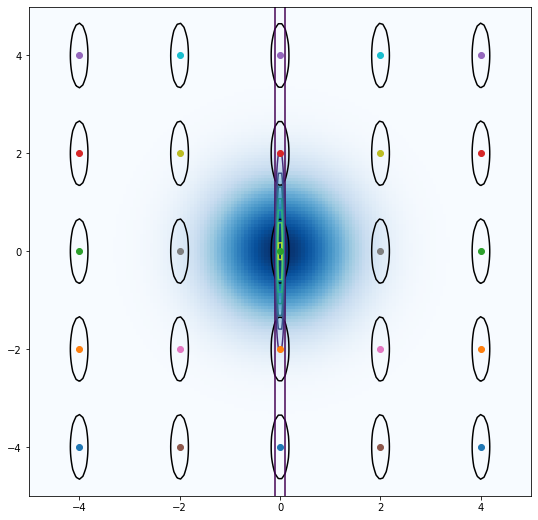

In [146]:
fig, ax = plt.subplots(figsize=[9,9])

gridpoints = [-4, -2, 0, 2, 4]
# gridpoints = [0]
inducing_points = [np.array([a,b]) for a, b in product(gridpoints, gridpoints)]
for x in inducing_points:
    @jit
    def kernfunx(x_): return learned_kernel(x, x_)
    plt.plot(x[0], x[1], "o")
    c = plot.plot_fun_2d(kernfunx, lims=(-5, 5), ax=ax, type="contour", levels=0, colors="black")

# plot.plot_fun_2d(proposal.pdf)
setup.plot()

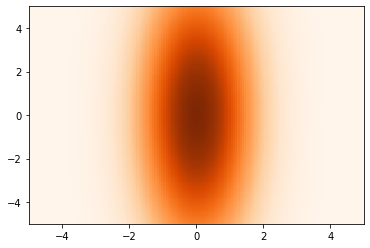

In [147]:
x = np.array([0,0])
def kernfunx(x_): return learned_kernel(x, x_)
plot.plot_fun_2d(kernfunx)